# Library

In [1]:
import numpy as np

from DataPreProcessing import dataOrdering, padding, lagging, dataSplitting, SpiralDataset_2inputs, dataSplitting, processData
from SindyShredModel import SINDySHRED, fit_SindyShred_param
from TestSindyShred import test_error, plot_sensors_comparison_shred, plot_sensors_comparison_sindy, plot_shred_comparison_1D, plot_shred_comparison_2D

# Load the data

The data must be of shape (nx, nt, nf, num_param) or (nx, ny, nt, nf, num_param) or (nx, ny, nz, nt, nf, num_param)

-nx, ny, nz are the spatial dimensions

-nt is the lenght of the temporal sequence

-nf is the number of features

-num_param is the number of parameters used. To be clearer: if num_param = 1, it means there is only one system generated by such 
parameter. If num_param is 10, it means you have 10 systems each one generated by its param.

In [2]:
data = np.load('uv_multi_param_100_n_50_L_20.npy')
data = data[:,:,:100,:,:]
nx, ny, nt, nf, num_param = data.shape
spatial_dim = nx*ny
dt = 0.05
#load the param beta_array
beta_array = np.linspace(0.1, 10, num_param)
print("data shape: ", data.shape)

data shape:  (50, 50, 100, 2, 100)


# DataProcessing

In [13]:
data_reshaped = dataOrdering(data)
print(type(data_reshaped))
n_states = data_reshaped.shape[-1]
lag = 11
data_padded = padding(data_reshaped, lag)
print("data_padded shape: ", data_padded.shape)
data_lagged = lagging(data_padded, lag)
print("data_lagged shape: ", data_lagged.shape)
num_sensors = 30



n_states:  5000
<class 'numpy.ndarray'>
data_padded shape:  (100, 111, 5000)
data_lagged shape:  (10000, 11, 5000)


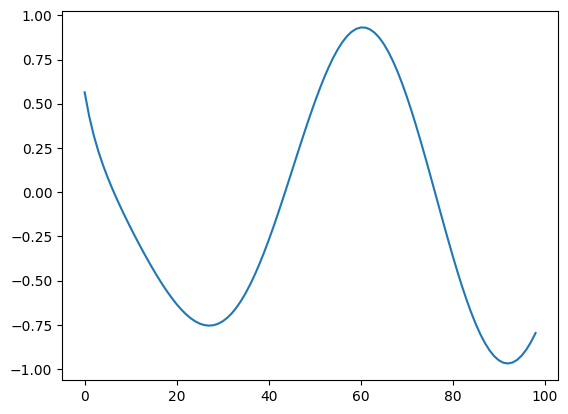

In [27]:
k = 20
plt.plot(data_lagged[k*100+1:100*(k+1), -1, 3000])

In [3]:
data_train, data_val, data_test = dataSplitting(data_lagged, beta_array, nt, num_param, 
                                                num_sensors=num_sensors, train_ratio=0.8, 
                                                val_ratio=0.1, param_split=False, noise=None)
del data_reshaped, data_padded, data_lagged


NameError: name 'data_lagged' is not defined

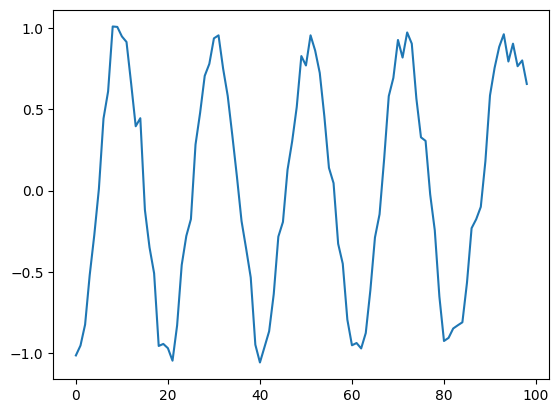

In [17]:
import matplotlib.pyplot as plt
k = np.random.randint(0, int(num_param*0.8))
plt.plot(data_train.data.X[k*100+1:(k+1)*100,-1,9])


In [4]:
lag = 11
num_sensors = 40
noise = 0.1 * np.max(data)
data_train, data_val, data_test = processData(data=data, parameters=beta_array, 
                                              lags=lag, num_sensors=num_sensors, 
                                              train_ratio=0.8, val_ratio=0.1,
                                              param_split = True,
                                              constant_params=True, noise=noise)

n_states:  5000
data ordered
data padded
data lagged
lagged_data_sens shape:  (10000, 11, 40)
data split


In [32]:
print("data_train shape: ", data_train.data.Y.shape)
print("data_val shape: ", data_val.data.X.shape)
print("data_test shape: ", data_test.data.X.shape)

data_train shape:  torch.Size([8000, 11, 5000])
data_val shape:  torch.Size([1000, 11, 40])
data_test shape:  torch.Size([1000, 11, 40])


# Define the model

In [5]:
hidden_size = 3
hidden_layers = 2
n_state = spatial_dim * nf
def create_z_labels(hidden_size):
    return [f"z{i+1}" for i in range(hidden_size)]
features_names = create_z_labels(hidden_size)
params_names = ['beta']
model = SINDySHRED(max_degree=1, features_name=features_names, dt=dt, param_names=params_names,
                   threshold=3*1e-1,
                   num_sensors=num_sensors, num_param=num_param, n_states = n_state,
                   hidden_layers=hidden_layers, hidden_size=hidden_size,
                   decoder_sizes=[40, 400], dropout=0.15)

# Train the model

In [18]:
batch_size = 25
#assert nt % batch_size == 0, 'batch_size must divide nt'

num_epochs = 1000
lambda_sindy = 1e-1



valid_error_list, train_error_list = fit_SindyShred_param(model, data_train, data_val, batch_size,
                                                          num_epochs, 1e-2, lambda_sindy, verbose=True, patience=8)

Training epoch 1
Training error: 0.18649719655513763
Validation error: 0.17587734758853912
z1' = 0.83*z2 + -0.73*beta*z1 + 0.59*beta*z2
z2' = 0.33*z1 + 0.88*z3 + 0.72*beta + -0.68*beta*z1 + -0.47*beta*z3
z3' = -0.98*z1 + -0.35*z2 + -0.43*z3 + 0.39*beta*z3
Training epoch 2
Training error: 0.13373203575611115
Validation error: 0.1375015676021576
Training epoch 3
Training error: 0.1267634481191635
Validation error: 0.13172362744808197
Training epoch 4
Training error: 0.14734351634979248
Validation error: 0.15557178854942322
Training epoch 5
Training error: 0.08755514770746231
Validation error: 0.09568662941455841
Training epoch 6
Training error: 0.091180719435215
Validation error: 0.10158607363700867
Training epoch 7
Training error: 0.07842996716499329
Validation error: 0.08714684098958969
Training epoch 8
Training error: 0.08874814212322235
Validation error: 0.09790778160095215
Training epoch 9
Training error: 0.09460684657096863
Validation error: 0.10266871750354767
Training epoch 10
Tr

# Test

In [30]:
beta_array[70]

7.1

error computation, divided into shred and sindy errors

In [19]:
error_shred, error_sindy = test_error(model, data_test)
print("SHRED error: ", error_shred)
print("SINDy error: ", error_sindy)

SHRED error:  tensor(0.0547)
SINDy error:  tensor(0.0031)


Plot a comparison between the real values in 3 random point across time, for a random parameter sampled from the test set

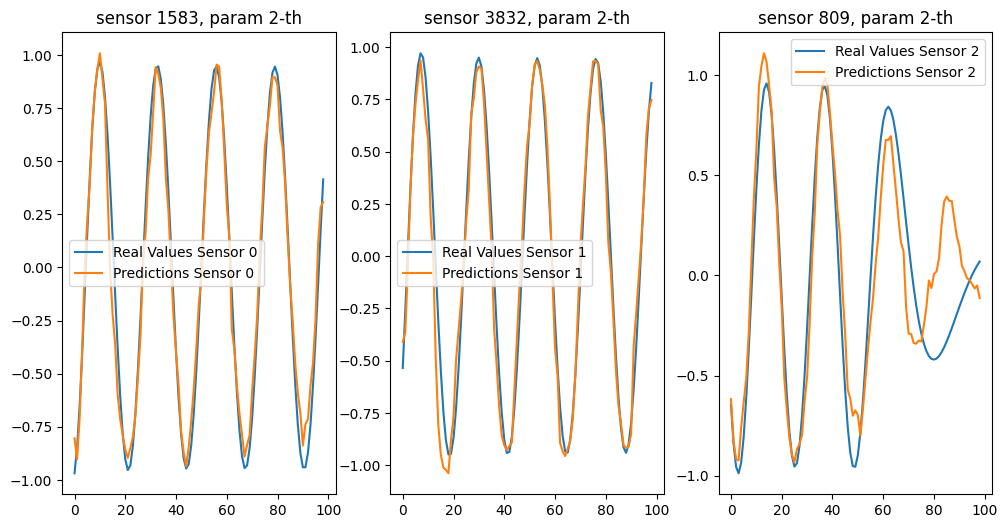

In [25]:
k = np.random.randint(0, int(num_param*0.1))
k = 1
plot_sensors_comparison_shred(model, data_test, nt, k)

Plot the hidden dimensions and the sindy predictions over time

z1' = 0.41*z3 + 0.55*beta*z2 + 0.66*beta*z3
z2' = 0.62*z1 + 1.05*z3 + -0.47*beta*z1 + 0.35*beta*z3
z3' = -0.48*z1 + -0.40*z3 + -0.52*beta*z1


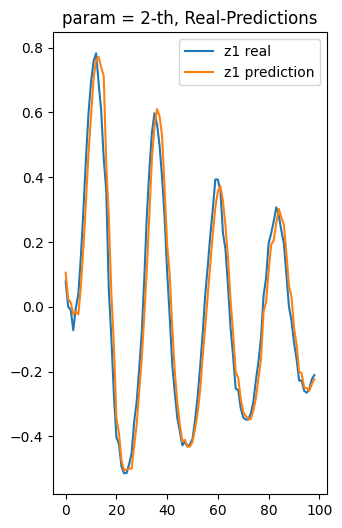

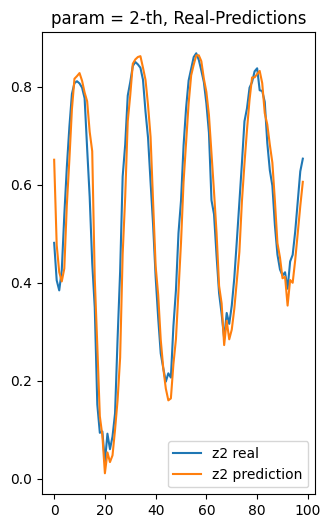

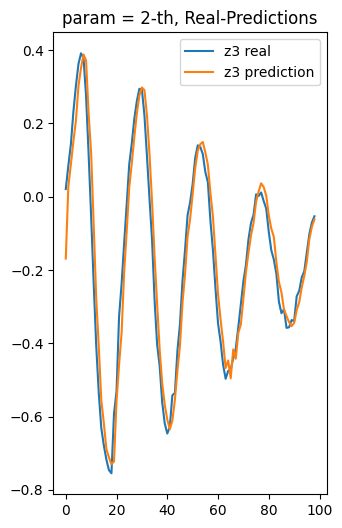

In [31]:

k = np.random.randint(0, int(num_param*0.1))
k = 1
plot_sensors_comparison_sindy(model, data_test, nt, k)

Plot the final prediction of the system. Visualize every feature at a random instant, for a random parameter from the test set

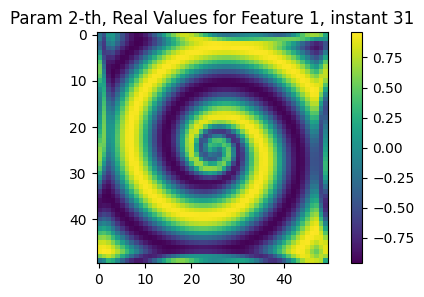

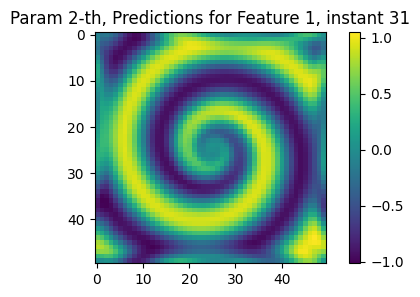

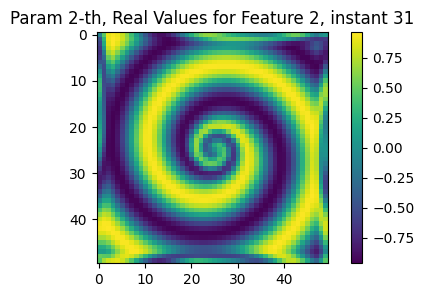

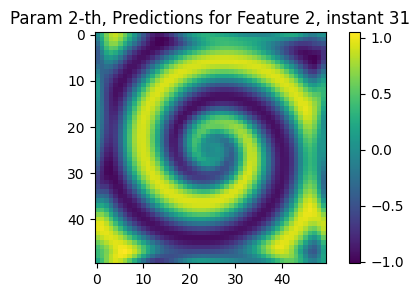

In [30]:
k = np.random.randint(0, num_param )
k = 1
instant = np.random.randint(0,nt)
plot_shred_comparison_2D(model, data_test, instant, nx, ny, nt, nf, k)

# Smoothening Effect

gru_smooth shape:  (1000, 3)


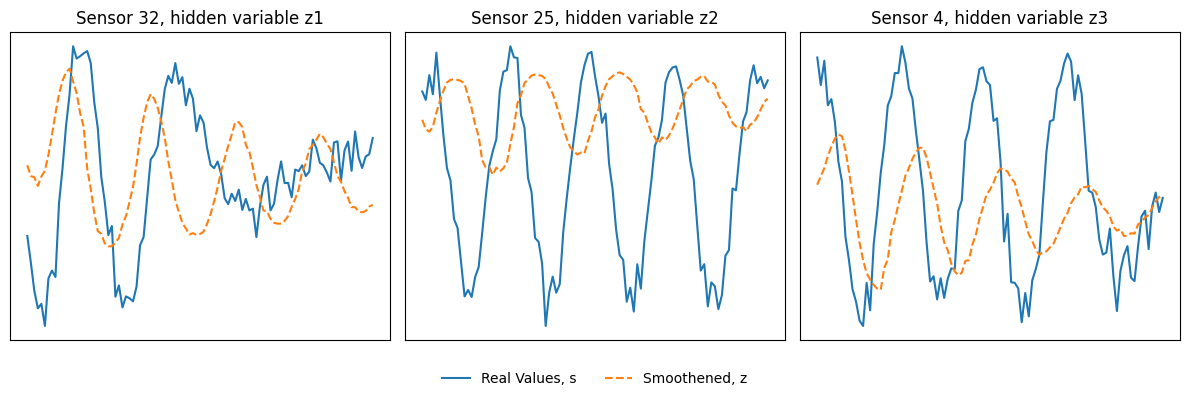

In [41]:
sensor_locations = np.random.randint(0, num_sensors, 3)

real_values = data_test.data.X[:,-1,:].detach().cpu().numpy()
gru_smooth = model.gru(data_test.data.X[:,1:,:]).detach().cpu().numpy()
sensor_locations = np.random.randint(0, num_sensors, 3)
k = 1

print("gru_smooth shape: ", gru_smooth.shape)
    
plt.figure(figsize=(12, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(f'Sensor {sensor_locations[i]}, hidden variable z{i+1}')
    plt.plot(real_values[k*nt+1:(k+1)*nt, sensor_locations[i]], label='Real Values', linestyle='-')
    plt.plot(gru_smooth[k*nt+1:(k+1)*nt, i], label='Smoothened', linestyle='--')

    # Remove numerical labels from x and y axes
    plt.xticks([])
    plt.yticks([])

# Create a unified legend outside the subplots
plt.figlegend(['Real Values, s', 'Smoothened, z'], loc='lower center', ncol=2, frameon=False)
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend

# Show the plot
plt.show()